# スパース回帰のための学習アルゴリズム

多くの（機械）学習課題では、多数の特徴量の候補はあっても、実際に予測や識別等に必要なのはごく少数である。しかし、事前にはどの候補が良いかは当然わからない。そのため、学習時には、データに応じて必要最低限の特徴量だけを選択し、残りを切り捨てて、スパースなモデルを定める必要がある（日本語では「疎」、密の対義語）。

__目次：__

- <a href="#background">スパース推定の背景</a>
- <a href="#coorddesc">2乗誤差を使っての座標降下法</a>
- <a href="#robust">頑健なスパース推定</a>

前の回では学習アルゴリズムを実装するための原型らしきものを学んだので、ここではそれを踏まえて、学習結果が一定のスパース性を有するための工夫を学ぶ。

<a id="background"></a>
## スパース推定の背景

Tibshirani氏の1996年の名著を引用すると、多数のパラメータがあるとき（特に標本数よりも多い場合）、スパースな推定結果を求めるべきだ、という理由が2つある。

一つは予測精度：

> _"[Naive estimates] often have low bias but large variance; prediction accuracy can sometimes be improved by shrinking or setting to 0 some coefficients."_

もう一つは解釈のしやすさ：

> _"With a large number of predictors, we often would like to determine a smaller subset that exhibits the strongest effects."_

実際、人の脳でも似たような原理が見られる。感覚器を通じて途轍もなく複雑な刺激を常に受けていることは事実だが、その刺激全体を脳全体で処理しているというよりは、刺激の特性によって「分担」している模様である。脳の細部まで調べると、特定の領域が活発に反応するのは、かなり特異的な刺激のみである。普段受けている刺激を多数の特徴量の組み合わせと見なすと、脳がどう反応するか予測するために必要なのはまさしくスパースなモデルである。（画像はHaxby et al., 2001より）

<img src="img/fmri_response.jpg" alt="Image source: Haxby et al. (2001)" width="480"/>


統計的な推論を行なう機械となると、入力が多数あるのだが、設計者が一定の「選択性」を持たせないと結果がスパースにはならない。

<img src="img/sparse_matrix.png" alt="Image: Sparse matrix image" width="240"/>

モデルによるところもあるのだが、基本的には、一つの特徴量の影響が実数値パラメータによって決まると思ってよく、その値をゼロにすることでその影響が無くなるケースがほとんど。よって、多くの場合は、制御するパラメータ$w \in \mathbb{R}^{d}$の要素の大半が零でありながら、それがスパースであるといえる。あとはスパースにさせた結果が高い汎化能力を持つかどうかだ。スパース性をダイレクトに測る場合は、$\ell_{0}$ノルムを使う：

\begin{align}
\|w\|_{0} = \left|\{j \in [d]: w_{j} \neq 0\}\right|.
\end{align}

よって、リスク最小化という文脈でいうと、リスクを$R(w) = \mathbf{E}_{Z} l(w;z)$としたとき、真の目的関数は下記の通り：

\begin{align}
\min_{w \in \mathbb{R}^{d}} R(w), \quad \text{s.t. } \|w\|_{0} \leq \gamma_{0}.
\end{align}

期待値は近似できるのだが、この制約を満たしながら最小化することは困難である。幸いにも、$\ell_{0}$ノルムを小さくすることは、$\ell_{1}$ノルムを小さくすることで実現できることは、多くの文献からわかってきている。この知見を踏まえて制約を変更すると、

\begin{align}
\min_{w \in \mathbb{R}^{d}} R(w), \quad \text{s.t. } \|w\|_{1} \leq \gamma_{1}
\end{align}

というもう少し攻めやすい問題設定になる。この制約付き最適化は、次の目的関数を用いることで近似できる。

\begin{align}
L_{\lambda}(w) = \frac{1}{n}\sum_{i=1}^{n} l(w;z_{i}) + \lambda \sum_{j=1}^{d}|w_{j}|.
\end{align}

この式を出発点として、有用な学習則をここから丁寧に見ていくことにする。

<a id="coorddesc"></a>
## 2乗誤差を使っての座標降下法

具体例から始めると説明しやすいので、典型例として、線形モデルの下で2乗誤差をロス関数とする状況を考える：

\begin{align}
l(w;z) = (y-w^{T}x)^{2}, \quad z=(x,y) \in \mathbb{R}^{d+1}.
\end{align}

このとき、先ほどの目的関数が下記のような形を取る。

\begin{align}
L_{\lambda}(w) = \frac{1}{n} \sum_{i=1}^{n} (y_{i}-w^{T}x_{i})^{2} + \lambda\|w\|_{1}.
\end{align}

難しいのは、絶対値を取っているので微分できない場合がある（パラメータの要素が一つでもゼロになる場合）。すべてのパラメータを一気に更新することは困難なので、愚直で速い方策として、「座標軸ごとに更新をすれば良い」という座標降下法（coordinate descent）がある。一次元ずつだと、更新が簡単になるというメリットがある。

まず、仮に$w$が局所解であるとする。このパラメータベクトルの$j$個目の要素は当然、零か非零のどれかである。事実として、$w_j = 0$であるならば、

\begin{align}
\left| \left.\frac{\partial L_{0}(w)}{\partial w_j}\right|_{w_j = 0} \right| \leq \lambda,
\end{align}

が成り立つことはわかっている。ここで示している$L_{0}(\cdot)$とは、$\ell_{1}$の項がない、制約無しの目的関数である。$w_j = 0$の場合に、もし逆にこの不等式が成り立たないのであれば、$w$が局所解でなくなる。

$w_j \neq 0$ならばどうだろうか。このときは$w_j$について偏微分は求められる：

\begin{align}
\left.\frac{\partial L_{\lambda}(w)}{\partial w_j}\right|_{w_j \neq 0} = 0 \iff \frac{w_{j}}{n}\sum_{i=1}^{n}x_{i,j}^{2} + \lambda \, \text{sign}(w_j) = \frac{1}{n}\sum_{i=1}^{n}\left(y_{i}-\sum_{l \neq j} w_{l}x_{i,l}\right)x_{i,j}.
\end{align}

式を整理するために、

\begin{align}
V_{j} = \frac{1}{n}\sum_{i=1}^{n}x_{i,j}^{2}
\end{align}

と置くと、偏微分がゼロになるための条件は、

\begin{align}
w_{j} = \frac{1}{n \, V_{j}}\sum_{i=1}^{n}\left(y_{i}-\sum_{l \neq j} w_{l}x_{i,l}\right)x_{i,j} - \frac{\lambda \, \text{sign}(w_j)}{V_{j}}
\end{align}

となる。左辺にも右辺にも$w_{j}$はあるが、明示的に解を求めることはできる:

\begin{align}
w_{j} = \frac{1}{V_{j}} S(\widetilde{g}_{j};\lambda)
\end{align}

ここで使っている関数は

\begin{align}
S(u;\gamma) = \text{sign}\,(u)\max\,(|u|-\gamma, 0)
\end{align}

と定義し、またその入力は

\begin{align}
\widetilde{g}_{j} = \frac{1}{n} \sum_{i=1}^{n}\left(y_{i}-\sum_{l \neq j} w_{l}x_{i,l}\right)x_{i,j} = -\left.\frac{\partial L_{0}(w)}{\partial w_j}\right|_{w_j = 0}.
\end{align}

と表記している。少し噛みしめてもらうと、この更新式では$w_{j}$がゼロになるのは、最初の条件として示した不等式が成り立つ場合のみである。

最後に計算する上で重要な点であるが、もし入力データが平均ゼロ、分散1.0と標準化されているのであれば、先ほどの$V_{j}$はすぐに計算できる。まず、$V_{j}$とサンプル分散の関係は

\begin{align}
V_{j} = \frac{n-1}{n} \text{var}\,\left\{x_{1,j},\ldots,x_{n,j}\right\},
\end{align}

となっているので、標準偏差が1.0であれば、各$j = 1,\ldots,d$に対して、$V_{j}=(n-1)/n$とする。

前の回のアルゴリズムクラスを踏まえて、少し改造するだけで上記のアルゴリズムは実装できる。まずはsoft threshold関数を用意する。

In [1]:
import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import models
import dataclass

In [2]:
def soft_thres(u,mar):
    '''
    The so-called "soft threshold" function, as made
    popular by the LASSO model and all related
    learning procedures.

    Input "u" will be an array, and "mar" will be the
    margin of the soft-threshold, a non-negative real
    value.
    '''
    return np.sign(u) * np.clip(a=(np.abs(u)-mar), a_min=0, a_max=None)

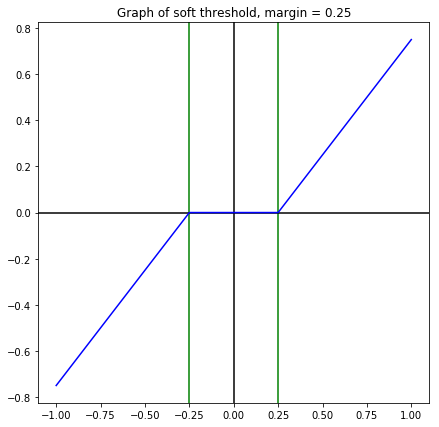

In [3]:
# Quick visualization.

xvals = np.linspace(-1, 1, 500)
marval = 0.25
yvals = soft_thres(u=xvals, mar=marval)

myfig = plt.figure(figsize=(7,7))
ax = myfig.add_subplot(1,1,1)
plt.axvline(x=0.0, color="black")
plt.axvline(x=marval, color="green")
plt.axvline(x=(-marval), color="green")
plt.axhline(y=0.0, color="black")
ax.plot(xvals, yvals, color="blue")
plt.title(("Graph of soft threshold, margin = "+str(marval)))
plt.show()

この`soft_thres`は先述の$S$に対応する。したがって`soft_thres(u,mar)`は$S$の返す値$S(u;\gamma)$に対応する。

続いては、$\ell_{1}$正則化項も兼ね備えた線形回帰モデルを用意する（正則化の度合いをつかさどる計数$\lambda$は`lamreg`とし表わす）。

In [4]:
# Model class with per-coordinate gradient computations.

class LinearL1(models.LinReg):
    '''
    Orthodox linear regression model, using squared
    error and regularization via the l1 norm. Good for
    realizing sparsity without giving up convexity.
    '''
    
    def __init__(self, data=None):
        super(LinearL1,self).__init__(data=data)

        
    def l_imp(self, w, X, y, lamreg=None):
        '''
        Input:
        w is a (d x 1) matrix of weights.
        X is a (k x numfeat) matrix of k observations.
        y is a (k x 1) matrix of labels in {-1,1}.
        lamreg is a regularization parameter (l2 penalty).

        Output:
        A vector of length k with losses evaluated at k points.
        '''
        if lamreg is None:
            return (y-self.predict(w=w,X=X))**2/2
        else:
            penalty = lamreg * np.abs(w).sum()
            return (y-self.predict(w=w,X=X))**2/2 + penalty

        
    def g_j_imp(self, j, w, X, y, lamreg=None):

        if lamreg is None:
            return (y-self.predict(w=w,X=X))*(-1)*np.take(a=X,
                                                          indices=[j],
                                                          axis=1)
        else:
            penalty = lamreg * np.sign(w[j,0])
            return (y-self.predict(w=w,X=X))*(-1)*np.take(a=X,
                                                          indices=[j],
                                                          axis=1) + penalty
        
    def g_j_tr(self, j, w, data, n_idx=None, lamreg=None):
        if n_idx is None:
            return self.g_j_imp(j=j, w=w, X=data.X_tr,
                                y=data.y_tr,
                                lamreg=lamreg)
        else:
            return self.g_j_imp(j=j, w=w, X=data.X_tr[n_idx,:],
                                y=data.y_tr[n_idx,:],
                                lamreg=lamreg)
    
    def g_j_te(self, j, w, data, n_idx=None, lamreg=None):
        if n_idx is None:
            return self.g_j_imp(j=j, w=w, X=data.X_te,
                                y=data.y_te,
                                lamreg=lamreg)
        else:
            return self.g_j_imp(j=j, w=w, X=data.X_te[n_idx,:],
                                y=data.y_te[n_idx,:],
                                lamreg=lamreg)


これで下ごしらえはできたので、あとは先述の座標降下法をアルゴリズムオブジェクトとして実装するだけである。

In [5]:
class Algo_CDL1:
    '''
    Coordinate descent (CD) implementation for minimization
    of the "LASSO" objective, namely the sum of squared errors
    regularized by an l1 penalty.
    '''
    
    def __init__(self, w_init, t_max, lamreg):
        self.w = w_init
        self.t = None
        self.t_max = t_max
        self.lamreg = lamreg
        
    def __iter__(self):
        self.t = 0
        # Shuffle up the indices before starting.
        self.idx = np.random.choice(self.w.size, size=self.w.size, replace=False)
        self.idxj = self.idx[0]
        return self
        
    def __next__(self):
        if self.t >= self.t_max:
            raise StopIteration

    def update(self, model, data):
        
        # Computations related to the update.
        n = data.X_tr.shape[0]
        modidx = (self.t-1) % self.w.size
        self.idxj = self.idx[modidx] # circuits around shuffled coords.
        self.w[self.idxj,0] = 0 # current para, but with jth coord set to zero.
        g_j = -np.mean(model.g_j_tr(j=self.idxj, w=self.w, data=data, lamreg=0))
        g_j = g_j * n / (n-1) # rescale
        
        # Compute the solution to the one-dimensional optimization,
        # using it to update the parameters.
        self.w[self.idxj,0] = soft_thres(u=g_j, mar=self.lamreg)
        
        # Monitor update.
        self.t += 1


基本的な構造は、これまでに扱ってきた`Algo_GD`とその仲間と酷似している。新しい部分を明確に表わすために、対応づけを一覧化しよう。

| `code` | Formal representation |
| ------ | :----------------: |
| `lam_l1` | $\lambda$ |
| `idx` | $\{1,2,\ldots,d\}$, shuffled |
| `idxj` | $j \in \{1,\ldots,d\}$ to update |
| `g_j` | $\widetilde{g}_{j}$ |

当然ながら、`t_max`は自由に設定できるので、その値がパラメータの数よりもはるかに大きいことはよくある。そのとき、ただ単にインデックスの先頭に戻れば良いのである。これができているのは、`modidx`で剰余演算をしているからである。その振る舞いを列挙しておくと、

\begin{align}
0,1,\ldots,d-1, 0, 1, \ldots, d-1, 0, 1, \ldots
\end{align}

と`t`が`t_max`になるまで繰り返す。

ほかのアルゴリズムを実装したときにも述べたが、`model`は抽象化したままである。その詳細について考える必要は今なく、ただ実行時に偏微分を計算してくれる何らかのモデルが用意されていれば良い。

ここからはその挙動を擬似データを通じて、調べていく。例に倣って、データのほうをまず初期化する。

In [6]:
# Initialize model.
mod = LinearL1()

ここで作成する人工データについて：

- この例はElements of Statistical Learning (ESL2、和訳：『統計的学習の基礎』)の英語版から引用している。具体的には、59ページのFigure 3.6（n=300）と78ページのFigure 3.16（n=100）に登場する。

- 至って標準的な線形モデルであるが、モデルを定めるパラメータベクトルがスパースであるという特徴を持つ。

- 入力データ$x$の経験平均と分散がそれぞれ0.0と1.0になるようにしている。

In [7]:
# Data prep, following ESL-II example.
n = 100 # training set size
d = 31 # number of inputs
d0 = 10 # number of *active* inputs
sigma_X = 1.0 # unit variance
corr = 0.85 # pairwise correlation coefficient
sigma_noise = math.sqrt(6.25) # stdev of additive noise
sigma_weights = math.sqrt(0.4) # stdev of randomly generated weights
cov_X = np.zeros(d*d).reshape((d,d)) + corr # prepare cov mtx
np.fill_diagonal(cov_X, sigma_X)

# Set up for a loop over trials.
num_trials = 100
lamval = 1.5
num_loops = 15
t_max = num_loops * d

# Storage for performance metrics.
loss_tr = np.zeros((num_trials,t_max+1), dtype=np.float32)
l0norm = np.zeros((num_trials,t_max+1), dtype=np.uint32)
truedist = np.zeros((num_trials,t_max+1), dtype=np.float32)

In [8]:
for tri in range(num_trials):
    
    #print("Running trial number", tri)
    
    # Initialize learning algorithm.
    w_init = 1*np.random.uniform(size=(d,1))
    
    al = Algo_CDL1(w_init=w_init,
                   t_max=t_max,
                   lamreg=lamval)
    
    # Generate the actual data, including "true" weights.
    wstar = np.zeros(d).reshape((d,1))
    idx_on = np.random.choice(d, size=d0, replace=False)
    wstar[idx_on,:] = np.random.normal(loc=0.0,
                                       scale=sigma_weights,
                                       size=d0).reshape((d0,1))
    X = np.random.multivariate_normal(mean=np.zeros(d), cov=cov_X, size=n)
    noise = np.random.normal(loc=0.0, scale=sigma_noise, size=(n,1))
    y = np.dot(X,wstar) + noise

    # Standardize the inputs to have unit (empirical) variance.
    X = (X-np.mean(X,axis=0)) / np.sqrt(np.var(X,axis=0))
    
    # Prepare the data object.
    data = dataclass.DataSet()
    data.init_tr(X=X, y=y)
    X = None
    y = None
    
    # Iterate the learning algorithm.
    idx = 1
    loss_tr[tri,0] = np.mean(mod.l_tr(w=w_init, data=data, lamreg=lamval))
    l0norm[tri,0] = np.nonzero(w_init)[0].size
    truedist[tri,0] = np.linalg.norm((w_init-wstar))
    for onestep in al:
        al.update(model=mod, data=data)
        # Record performance
        loss_tr[tri,idx] = np.mean(mod.l_tr(w=al.w, data=data, lamreg=lamval))
        l0norm[tri,idx] = np.nonzero(al.w)[0].size
        truedist[tri,idx] = np.linalg.norm((al.w-wstar))
        idx += 1

はじめに、$\lambda$を固定しておいて、関心のある指標の軌跡を見てみる。

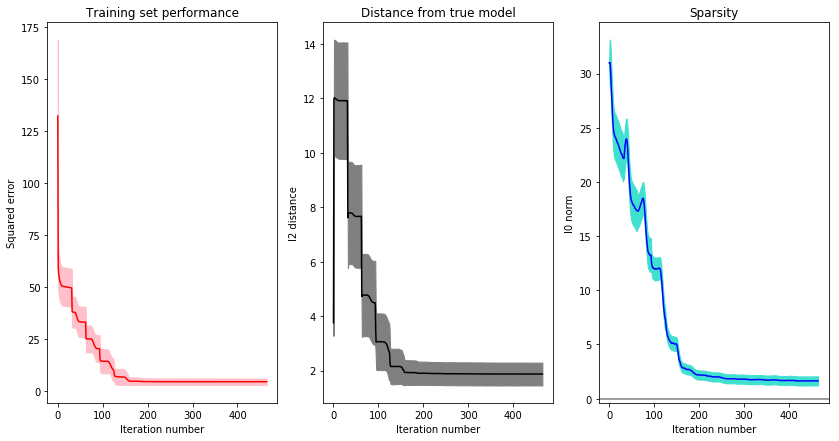

In [9]:
# Visualize the performance trajectories.

tvals = np.arange((t_max+1))

# Average over trials.
myfig = plt.figure(figsize=(14,7))

ax_tr = myfig.add_subplot(1, 3, 1)
loss_ave = np.mean(loss_tr, axis=0)
loss_sd = np.std(loss_tr, axis=0)
plt.fill_between(tvals, loss_ave-loss_sd,
                 loss_ave+loss_sd, color="pink")
ax_tr.plot(tvals, loss_ave, "-", color="red")
plt.ylabel("Squared error")
plt.xlabel("Iteration number")
plt.title("Training set performance")

ax_dist = myfig.add_subplot(1, 3, 2)
dist_ave = np.mean(truedist, axis=0)
dist_sd = np.std(truedist, axis=0)
plt.fill_between(tvals, dist_ave-dist_sd,
                 dist_ave+dist_sd, color="gray")
ax_dist.plot(tvals, dist_ave, "-", color="black")
plt.ylabel("l2 distance")
plt.xlabel("Iteration number")
plt.title("Distance from true model")

ax_spar = myfig.add_subplot(1, 3, 3)
spar_ave = np.mean(l0norm, axis=0)
spar_sd = np.std(l0norm, axis=0)
plt.fill_between(tvals, spar_ave-dist_sd,
                 spar_ave+dist_sd, color="turquoise")
ax_spar.plot(tvals, spar_ave, "-", color="blue")
plt.axhline(y=0, color="gray")
plt.ylabel("l0 norm")
plt.xlabel("Iteration number")
plt.title("Sparsity")

plt.show()


ここで注目すべきは、下記のパラメータである。

- `n`: 標本数

- `d`: 学習の対象となるパラメータの数

- `d0`: 学習しうるパラメータのうち、非零のパラメータの数

- `t_max`: 最大の反復回数

- `lam_l1`: $\ell_{1}$正則化項をつかさどる計数$\lambda$

- `sigma_noise`: 加法ノイズの度合い

__練習問題:__

0. 上記の数値実験では、$\lambda$の値を色々と変えてみること（`Algo_CDL1`に渡す`lamreg`である）。小さい値（例：$\lambda=0.01$）から大きい値（例：$\lambda=5$）まで調べてみると、学習の結果がどのように変わっていくか。

0. $\lambda$の値と、学習される$w$への$\ell_{1}$制約とはどういう関係にあるか。

___

データを持っている時点でも、また$\ell_{1}$のちょうど良い制約がわかっていても、$\lambda$をどう設定すれば良いかは自明ではない。そのため、普通のやり方としては、$\lambda$の候補をたくさん用意し、全部に対して上記のアルゴリズムを実行し、一番良いほうを選ぶ、という流れで学習を進めていく。一つの利点としては、多数の$\lambda$候補を試すと、学習結果を再利用することができるのである。最初はおそらく恣意的に決める初期値であるが、そのあとは段々ともっともらしい解を初期値として使える、warm startの効果が働く。

これを実装することは単純である。`todo_lambda`で$\lambda$の候補を用意し、アルゴリズムを一通り実行したあと、`w_init`に学習結果`w_est`を代入するだけである：

In [10]:

# Data prep, following ESL-II example.
n = 100 # training set size
d = 31 # number of inputs
d0 = 10 # number of *active* inputs
sigma_X = 1.0 # unit variance
corr = 0.85 # pairwise correlation coefficient
sigma_noise = math.sqrt(6.25) # stdev of additive noise
sigma_weights = math.sqrt(0.4) # stdev of randomly generated weights
cov_X = np.zeros(d*d).reshape((d,d)) + corr # prepare cov mtx
np.fill_diagonal(cov_X, sigma_X)

# Set up for a loop over trials and lambda values.
num_trials = 100
todo_lambda = np.logspace(start=math.log10(1/100), stop=math.log10(2.5), num=150)
num_loops = 15
t_max = num_loops * d

# Storage for performance metrics.
loss_tr = np.zeros((num_trials,todo_lambda.size), dtype=np.float32)
l0norm = np.zeros((num_trials,todo_lambda.size), dtype=np.uint32)
truedist = np.zeros((num_trials,todo_lambda.size), dtype=np.float32)


In [11]:
for tri in range(num_trials):
    
    # Initialize learning algorithm.
    w_init = 1*np.random.uniform(size=(d,1))
    
    for l in range(todo_lambda.size):
        
        lamval = todo_lambda[l]
        
        # Use warm starts when available.
        if l > 0:
            w_init = al.w

        al = Algo_CDL1(w_init=w_init,
                       t_max=t_max,
                       lamreg=lamval)
    
        # Generate the actual data, including "true" weights.
        wstar = np.zeros(d).reshape((d,1))
        idx_on = np.random.choice(d, size=d0, replace=False)
        wstar[idx_on,:] = np.random.normal(loc=0.0,
                                           scale=sigma_weights,
                                           size=d0).reshape((d0,1))
        X = np.random.multivariate_normal(mean=np.zeros(d), cov=cov_X, size=n)
        noise = np.random.normal(loc=0.0, scale=sigma_noise, size=(n,1))
        y = np.dot(X,wstar) + noise

        # Standardize the inputs to have unit (empirical) variance.
        X = (X-np.mean(X,axis=0)) / np.sqrt(np.var(X,axis=0))

        # Prepare the data object.
        data = dataclass.DataSet()
        data.init_tr(X=X, y=y)
        X = None
        y = None
    
        # Iterate the learning algorithm.
        for onestep in al:
            al.update(model=mod, data=data)
        
        # Record performance based on final output.
        loss_tr[tri,l] = np.mean(mod.l_tr(w=al.w, data=data, lamreg=lamval))
        l0norm[tri,l] = np.nonzero(al.w)[0].size
        truedist[tri,l] = np.linalg.norm((al.w-wstar))
        

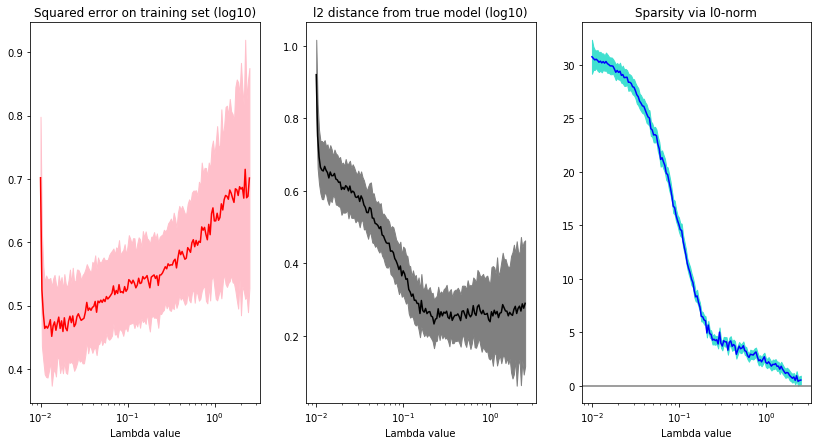

In [12]:
# Visualize the performance over lambda grid.

# Average over trials.
myfig = plt.figure(figsize=(14,7))

ax_tr = myfig.add_subplot(1, 3, 1)
ax_tr.set_xscale('log')
loss_ave = np.mean(loss_tr, axis=0)
loss_sd = np.std(loss_tr, axis=0)
logerr = loss_sd / (math.log(10)*loss_ave) # for error bars when using log scale
plt.fill_between(todo_lambda, np.log10(loss_ave)-logerr,
                 np.log10(loss_ave)+logerr, color="pink")
ax_tr.plot(todo_lambda, np.log10(loss_ave), "-", color="red")
plt.xlabel("Lambda value")
plt.title("Squared error on training set (log10)")

ax_dist = myfig.add_subplot(1, 3, 2)
ax_dist.set_xscale('log')
dist_ave = np.mean(truedist, axis=0)
dist_sd = np.std(truedist, axis=0)
logerr = loss_sd / (math.log(10)*loss_ave) # for error bars when using log scale
plt.fill_between(todo_lambda, np.log10(dist_ave)-logerr,
                 np.log10(dist_ave)+logerr, color="gray")
ax_dist.plot(todo_lambda, np.log10(dist_ave), "-", color="black")
plt.xlabel("Lambda value")
plt.title("l2 distance from true model (log10)")

ax_spar = myfig.add_subplot(1, 3, 3)
ax_spar.set_xscale('log')
spar_ave = np.mean(l0norm, axis=0)
spar_sd = np.std(l0norm, axis=0)
plt.fill_between(todo_lambda, spar_ave-dist_sd,
                 spar_ave+dist_sd, color="turquoise")
ax_spar.plot(todo_lambda, spar_ave, "-", color="blue")
plt.axhline(y=0, color="gray")
plt.xlabel("Lambda value")
plt.title("Sparsity via l0-norm")

plt.show()


注目すべき点：

- より大きな$\lambda$にすると、よりスパースな推定結果が得られることは明らか。要するに$\ell_{1}$（および$\ell_{0}$）の制約が厳しくなってくる。

- 明確な__バイアス__と__バリアンス__（分散）のトレードオフが先の例で見られる。制約設定が厳しすぎると、最適解がそれを満たさない可能性があって、最初から的外れになってしまう（バイアスを食らう）。一方、制約が緩すぎるのもだめで、標本が限られているなかで決めないといけないパラメータ数が多くなると解が定まらず、サンプルごとの分散が甚だ大きくなってしまう。

- 実験的な知見として、$w^{\ast}$と同程度のスパース性を持つベクトルのほうが良いパフォーマンスを記録する傾向が見られる。

__練習問題:__

0. 上の例では、小さい$\lambda$から始まり、大きい$\lambda$で終わるようにしている。この大小を逆にしてみてください（大きい値から始まるように）。最高の成績水準が変わるか。それを実現する$\lambda$の値が、大小・小大の順番によって変わるか。

0. 先ほどのwarm startsをやめて、すべての$\lambda$に対してまったく同じ初期値（固定された`w_init`）を使って実行してみること。最高の成績水準が変わるか。また、それを実現する$\lambda$の値が変わるか。

0. 候補としての$(\lambda_{0},\ldots,\lambda_{k})$を決める著名な方法として、対数スケールで一定の間隔にする。つまり、$\log\lambda_{i} - \log\lambda_{i-1} = c > 0$で、この定数$c$はすべての$i$に対して共通している。あとは最大値と最小値を決めることだが、標準的な値は次の通りである（Bühlmann, and Van De Geer, 2011）。データの表記方法として、$y=(y_{1},\ldots,y_{n})$で応答を表わし、$x_{(j)}$で入力行列の$j$番目の列を表わす（$x_{(j)} = (x_{1,j},\ldots,x_{n,j})$）。この表記を使って、最大値と最小値の設定は
<br><br>
\begin{align}
\lambda_{0} = 1/n, \quad \lambda_{k} = \max \left\{|\langle y, x_{(j)}\rangle|/n:j=1,\ldots,d \right\}.
\end{align}
<br>
となる。自分で実装し、有効性を検証すること。

0. 全パラメータを何周するかによって、学習結果がどの程度変わるか。極端に少ない（各要素を一度だけ更新する）場合と、何度も更新する場合、それぞれを試して比較すること。

0. 前の練習問題と同様に、warm startsをやめて、$\lambda$候補をすべて同一の初期値を使って検証すること。試行を重ねて、パフォーマンスの平均・分散、スパース性の平均・分散を調べて、warm starts有りと無しの場合を比較してみること。

0. 試行ごとに、もっとも良い成績を残した$\lambda$の値を記録するようにコードを改造すること。これらの値の平均と分散はどうか。サンプルのばらつきに対して、もっとも良い$\lambda$の値が敏感に思われるか。

0. 次の属性を`Algo_CDL1`に追加してください：`w_old`、`thres`、`diff`の3つである。`w.size`（つまり$d$）回の更新をするごとに、`diff`に`w`と`w_old`の距離を代入してから、`w_old`に`w`を代入する。新たな終了条件をここで追加：`diff`が閾値`thres`を下回ると、直ちに終了する。

0. 先の問題の続きだが、`thres`を使った終了条件では、だいたい何周すれば収束するか。また、この収束速度が$\lambda$の値にどう依存するか。

0. 何周もするなら、多くの$w_{j}$がずっとゼロである。それにもかかわらず、毎回同じ更新式のための計算はするので、無駄な計算として省ける。すべてのパラメータを何度も見るのではなく、パラメータが一旦ゼロになると二度と更新しない（`idx`のなかから削除する）、という方策も有名である。これを実装し、成績を調べること。通常のやり方と比較し、性能がどう変わるか。計算時間はどうか。

## References:

- Bühlmann, Peter, and Sara Van De Geer. Statistics for high-dimensional data: methods, theory and applications. Springer Science & Business Media, 2011.
- Haxby, James V., et al. "Distributed and overlapping representations of faces and objects in ventral temporal cortex." Science 293.5539 (2001): 2425-2430.